# Time series analysis with Dionysus2

### Some wrapper functions to analyze time series data with Dionysus2
http://www.mrzv.org/software/dionysus2/

In [12]:
# data
import numpy as np
import pandas as pd
import time
from scipy import stats
from scipy.special import binom
from scipy.spatial import distance_matrix
import itertools
from collections import Counter
from math import sin
from random import random
import random
from numpy.random import choice
import math

# dionysus
import dionysus as d

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import collections  as mc
import matplotlib.path as mpath
import matplotlib.patches as mpatches

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [13]:
def rolling_window(a, window):
    '''
    Take in an array and return array of rolling windows of specified length
    
    Parameters:
    - a: numpy array that will be windowed
    - window: integer that will be the length of the window
    
    Returns:
    - a_windowed: array where each entry is an array of length window
    '''
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    a_windowed = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return a_windowed

In [14]:
def time_series_to_point_cloud(time_series, dimension_embed=2):
    '''
    Convert a time series into a point cloud in the dimension specified by dimension_embed
    
    Parameters:
    - time_series: numpy array of time series values
    - dimension_embed: dimension of Euclidean space in which to embed the time series into by taking windows of dimension_embed length,
        e.g. if the time series is [t_1,...,t_n] and dimension_embed is 2, then the point cloud would be [(t_0, t_1), (t_1, t_2),...,(t_(n-1), t_n)]
        
    Returns:
    - point_cloud_normalized: point cloud normalized to take values between [0, 1]
    '''

    assert len(time_series) >= dimension_embed, 'dimension_embed larger than length of time_series'
    
    # time series to float type
    time_series = time_series.astype(float)

    # compute point cloud
    point_cloud = rolling_window(a=time_series, window=dimension_embed)
    
    return np.array(point_cloud)

In [28]:
def point_cloud_to_persistent_homology(point_cloud, epsilon_range, max_simplex_dim):
    # take unique points in the point cloud only
    point_cloud = np.unique(point_cloud, axis=0)

    # build filtration with fill_rips
    filtration = d.fill_rips(point_cloud, max_simplex_dim, 1.0)
    
    # calculate persistent homology
    persistence = d.homology_persistence(filtration)
    
    # initialize persistence diagrams
    diagrams = d.init_diagrams(persistence, filtration)
    
    ep_ran_len = len(epsilon_range)
    
    homology = {dimension: np.zeros(ep_ran_len) for dimension in range(max_simplex_dim)}

    for dimension, diagram in enumerate(diagrams):
        if dimension < max_simplex_dim:
            homology[dimension] = np.array([np.array(((epsilon_range >= point.birth) & (epsilon_range <= point.death)).astype(int)) 
                                        for point in diagram
                                       ]).sum(axis=0)
        
    return homology

In [16]:
def time_series_to_persistent_homology(time_series, epsilon_range, max_simplex_dim):
    '''
    Wrapper function that takes in a time series and outputs
    the persistent homology object, along with other
    auxiliary objects.
    
    Parameters: 
    - time_series: Numpy array of time series values
    - num_epsilon_steps: Either a positive integer or a list of epsilon values. If an integer, it is the number of segments the inverval [0, 1] 
    will be divided into. The method parameter will determine how the division will be set.
    - max_simplex_dim: Integer denoting the maximum dimension of simplexes to create in filtration
    
    Returns:
    '''
    
    # create point cloud from time series
    point_cloud = time_series_to_point_cloud(time_series, dimension_embed=max_simplex_dim)
    
#     # take unique points in the point cloud only
#     point_cloud = np.unique(point_cloud, axis=0)

#     # build filtration with fill_rips
#     filtration = d.fill_rips(point_cloud, max_simplex_dim, 1.0)
    
#     # calculate persistent homology
#     persistence = d.homology_persistence(filtration)
    
#     # initialize persistence diagrams
#     diagrams = d.init_diagrams(persistence, filtration)
    
#     homology = {}

#     for dimension in range(max_simplex_dim):
#         homology[dimension] = np.array([np.array(((epsilon_range >= point.birth) & (epsilon_range <= point.death)).astype(int)) 
#                                         for point in diagrams[dimension]
#                                        ]).sum(axis=0)
        
#     return homology

    homology = point_cloud_to_persistent_homology(point_cloud=point_cloud, epsilon_range=epsilon_range, max_simplex_dim=max_simplex_dim)
    return homology

In [17]:
def betti(time_series, epsilon_range, max_simplex_dim, agg=None):
    homology = time_series_to_persistent_homology(time_series=time_series,
                                                  epsilon_range=epsilon_range,
                                                  max_simplex_dim=max_simplex_dim)
    
    if agg == 'sum':
        return np.array(homology.values()).sum().sum()
    elif agg == 'mean':
        return np.array(homology.values()).mean()
    elif agg == 'median':
        return np.median(np.array(homology.values()))
    else:
        return np.array(homology.values())

In [18]:
def time_series_rolling_betti(time_series, epsilon_range, max_simplex_dim, window, agg=None):
    betti_results = [betti(time_series=wdw,
                       epsilon_range=epsilon_range,
                       max_simplex_dim=max_simplex_dim,
                       agg=agg) for wdw in rolling_window(time_series, window)]
    
    return pd.concat([time_series, pd.Series(data=betti_results, index=time_series.index[window-1:], name='betti')], axis=1)

In [19]:
def simplex_conditions(row, columns, n):
    '''
    Helper function to apply conditions that single 
    out a simplex. To be used applied to a pandas DataFrame.
    The columns are assumed to be {1, 2,..., n, (1, 2), (1, 3), ...} where 
    n is the dimension of simplex being checked for. The columns 1, ..., n
    are assumed to be integer type and the columns of the form (i, j) are 
    assumed to be tuple type, and to have i < j.
    
    Parameters:
    - row: row of the DataFrame
    - columns: list of the columns of the DataFrame
    - n: dimnesion of the simplex being checked for
    
    Returns:
    - Boolean based on whether the row in question satisfies simplex conditions
    '''
    
    for col in columns:
        if type(col) == int and col < n:
            if row[col] == row[col+1]:
                return False
            
        elif type(col) == tuple:
            if row[col[1]] != row[col]:
                return False
            
    else:
        return True

In [27]:
def create_n_simplexes(one_spxs, n):
    '''
    Helper function that creates an array of the 
    n simplexes from the data frame of the 
    one simplexes
    
    Parameters:
    - one_spxs: DataFrame of one simplexes 
    - n: dimension of simplexes being created
    
    Returns:
    - list of n+1-tuples that represent n simplexes
    '''
    
    # create copy of one simplexes
    df = one_spxs
    
    # iteratively merge on one simplexes
    for combo in list(itertools.combinations(range(n+1), 2))[1:]:
        if combo[0] == 0:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={1: combo[1]}),
                on=0,
                how='left'
            ).dropna().drop_duplicates().astype(int)
        else:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={0: combo[0], 1: combo}),
                on=combo[0],
                how='left'
            ).dropna().drop_duplicates().astype(int)
    
    # extract vertexes that make up the n simplexes
    cols = df.columns

    n_simplexes = []
    if len(df) > 0:
        n_simplexes = [tuple(simplex) 
                       for simplex in df[df.apply(lambda x: simplex_conditions(x, cols, n), axis=1)][[col 
                                                                                                      for col in df.columns if type(col) == int]].values]
    
    return n_simplexes

In [21]:
def plot_two_simplexes(point_cloud, distance_matrix, epsilon, one_simplexes_color='#6DA5BA', two_simplexes_color='#E0513B'):
    one_simplicies = [(x,y) for (x,y) in zip(*np.where(distance_matrix <= epsilon)) if x < y]
    two_simplicies = create_n_simplexes(one_spxs=pd.DataFrame(one_simplicies), n=2)

    lines = [(point_cloud[x], point_cloud[y]) for (x, y) in one_simplicies]

    fig, ax = plt.subplots(figsize=(7, 7))

    lc2 = mc.LineCollection(
        lines,
        colors=one_simplexes_color,
        linewidths=0.5
    );

    pd.DataFrame(point_cloud).rename(columns={0: 'x', 1: 'y'}).plot(
        kind='scatter',
        x='x',
        y='y',
        ax=ax,
        s=7,
        c=one_simplexes_color
    );

    ax.add_collection(lc2);
    ax.autoscale();

    for two_simplex in two_simplicies:
        Path = mpath.Path
        path_data = [
                (Path.MOVETO, point_cloud[two_simplex[0]]),
                (Path.LINETO, point_cloud[two_simplex[1]]),
                (Path.LINETO, point_cloud[two_simplex[2]]),
                (Path.CLOSEPOLY, point_cloud[two_simplex[0]]),
                ]
        codes, verts = zip(*path_data)
        path = mpath.Path(verts, codes)
        patch = mpatches.PathPatch(path, facecolor=two_simplexes_color, alpha=0.2);
        ax.add_patch(patch);

    plt.show();

In [22]:
def plot_two_simplexes_multi(point_cloud, distance_matrix, epsilon_list, one_simplexes_color='#6DA5BA', two_simplexes_color='#E0513B'):
    lgth = len(epsilon_list)
    
    fig, axs = plt.subplots(1,lgth, figsize=(7*lgth, 7))
    
    for idx, epsilon in enumerate(epsilon_list):
        one_simplicies = [(x,y) for (x,y) in zip(*np.where(distance_matrix <= epsilon)) if x < y]
        two_simplicies = create_n_simplexes(one_spxs=pd.DataFrame(one_simplicies), n=2)

        lines = [(point_cloud[x], point_cloud[y]) for (x, y) in one_simplicies]

    #     fig, ax = plt.subplots(figsize=(7, 7))

        lc2 = mc.LineCollection(
            lines,
            colors=one_simplexes_color,
            linewidths=0.5
        );

        pd.DataFrame(point_cloud).rename(columns={0: 'x', 1: 'y'}).plot(
            kind='scatter',
            x='x',
            y='y',
            ax=axs[idx],
            s=7,
            c=one_simplexes_color
        );
        
        axs[idx].set_title('epsilon = {EPSILON}'.format(EPSILON=epsilon))

        axs[idx].add_collection(lc2);
        axs[idx].autoscale();

        for two_simplex in two_simplicies:
            Path = mpath.Path
            path_data = [
                    (Path.MOVETO, point_cloud[two_simplex[0]]),
                    (Path.LINETO, point_cloud[two_simplex[1]]),
                    (Path.LINETO, point_cloud[two_simplex[2]]),
                    (Path.CLOSEPOLY, point_cloud[two_simplex[0]]),
                    ]
            codes, verts = zip(*path_data)
            path = mpath.Path(verts, codes)
            patch = mpatches.PathPatch(path, facecolor=two_simplexes_color, alpha=0.2);
            axs[idx].add_patch(patch);

plt.show();

# Toy examples

## Noisy circle

In [23]:
n_pts = 50
rrnd = 0.5
alpha = [0.4, 0.6, 0.2, 0.4]

pc = [[np.cos(x*np.pi) + alpha[0]*random.random(), np.sin(x*np.pi) + alpha[1]*random.random()] for 
      x in [(r + random.random()*rrnd)*(1/float(n_pts)) for r in range(-n_pts, n_pts)]]

dm = distance_matrix(pc, pc)

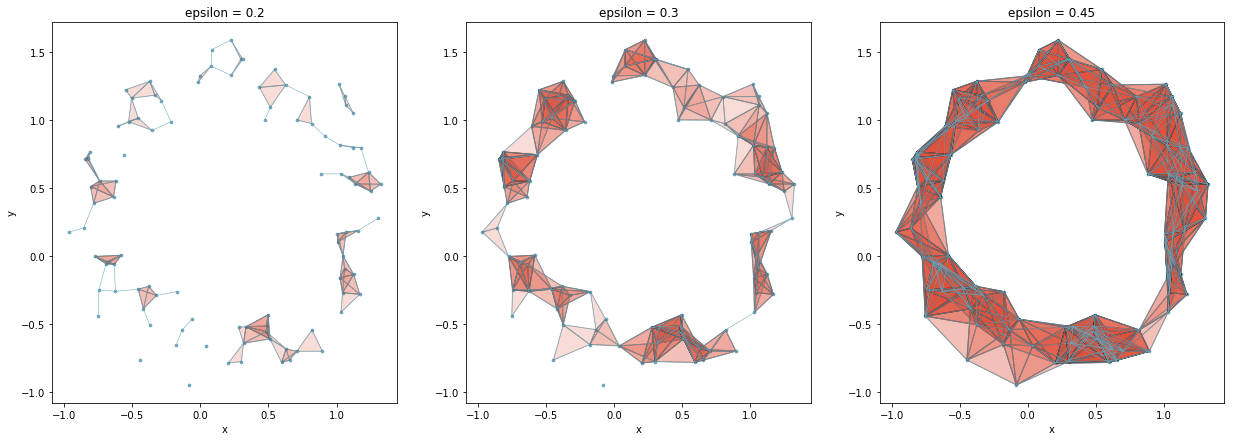

In [24]:
plot_two_simplexes_multi(point_cloud=pc, distance_matrix=dm, epsilon_list=[0.2, 0.3, 0.45], one_simplexes_color='#6DA5BA', two_simplexes_color='#E0513B')

In [29]:
h = point_cloud_to_persistent_homology(point_cloud=pc, epsilon_range=np.array([x*0.01 for x in range(100)]), max_simplex_dim=2)

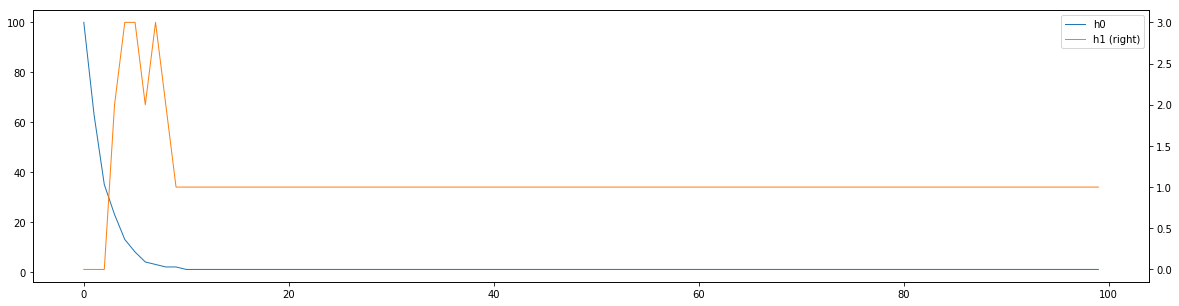

In [30]:
pd.DataFrame(h).rename(columns={0: 'h0', 1: 'h1'}).plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    secondary_y='h1'
);

## Noisy sine

In [31]:
n_steps = 100
rrand = 20
alpha = 0.6

ts = np.sin([(16*np.pi*x + rrand*random.random())/(n_steps) + alpha*random.random() for x in range(n_steps)])

pcld = time_series_to_point_cloud(time_series=np.array(ts), dimension_embed=2)

dm = distance_matrix(pcld, pcld)

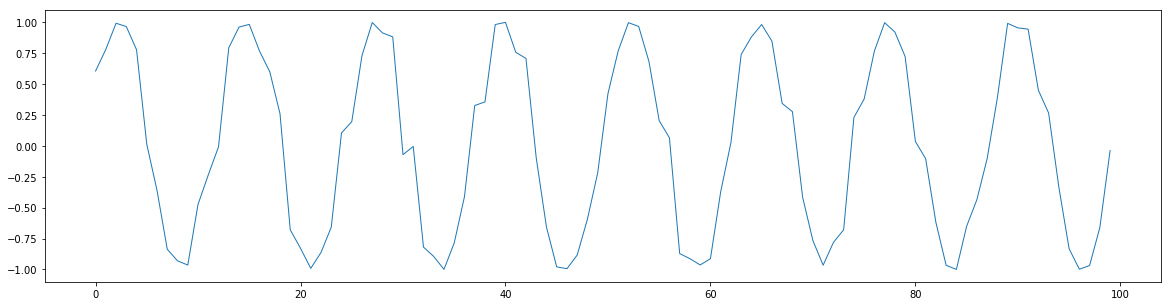

In [32]:
pd.DataFrame(ts).plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    legend=False
);

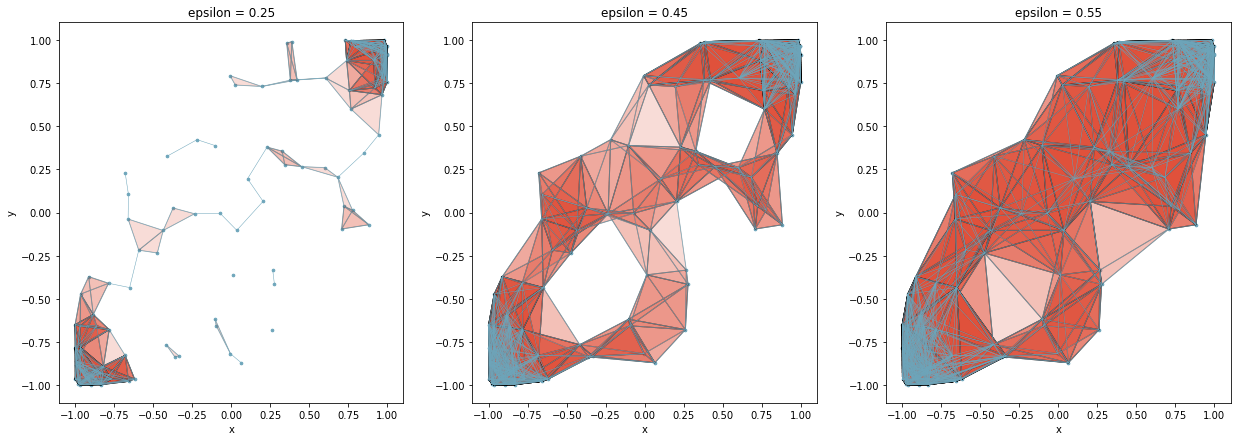

In [33]:
plot_two_simplexes_multi(
    point_cloud=pcld,
    distance_matrix=dm,
    epsilon_list=[0.25, 0.45, 0.55],
    one_simplexes_color='#6DA5BA',
    two_simplexes_color='#E0513B'
)

### Betti matrix

In [34]:
bmtx = betti(time_series=ts, epsilon_range=np.array([x*.01 for x in range(100)]), max_simplex_dim=2, agg=None)

In [35]:
bmtx_df = pd.DataFrame(bmtx.T, index=np.array([x*.01 for x in range(100)])).rename(columns={
    0: 'betti_0',
    1: 'betti_1'
})

In [36]:
bmtx_df.head()

,betti_0,betti_1
0.00,99,0
0.01,47,0
0.02,32,0
0.03,18,1
0.04,14,2


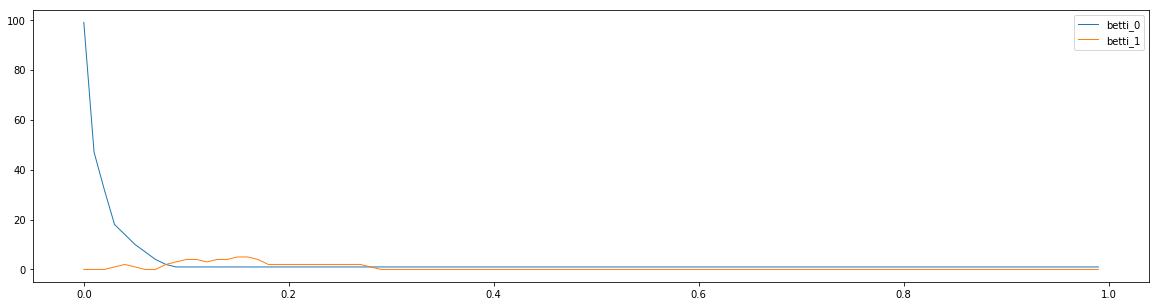

In [37]:
bmtx_df.plot(
    kind='line',
    lw=1,
    secondary_y='beta_1',
    figsize=(20, 5)
);

### Rolling window Betti sum

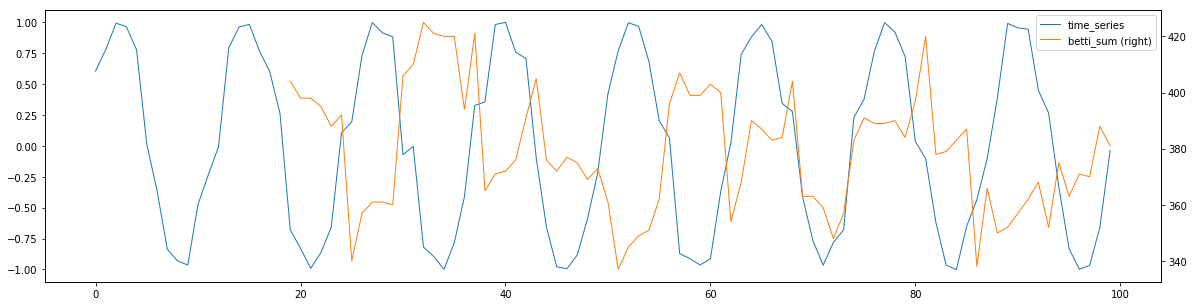

In [38]:
bt_sum = time_series_rolling_betti(time_series=pd.Series(ts),
                                   epsilon_range=np.array([y*.01 for y in range(100)]),
                                   max_simplex_dim=2,
                                   window=20,
                                   agg='sum')

bt_sum.rename(columns={'betti': 'betti_sum', 0: 'time_series'}, inplace=True)

bt_sum.plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    secondary_y='betti_sum'
);

## Increasing randomness

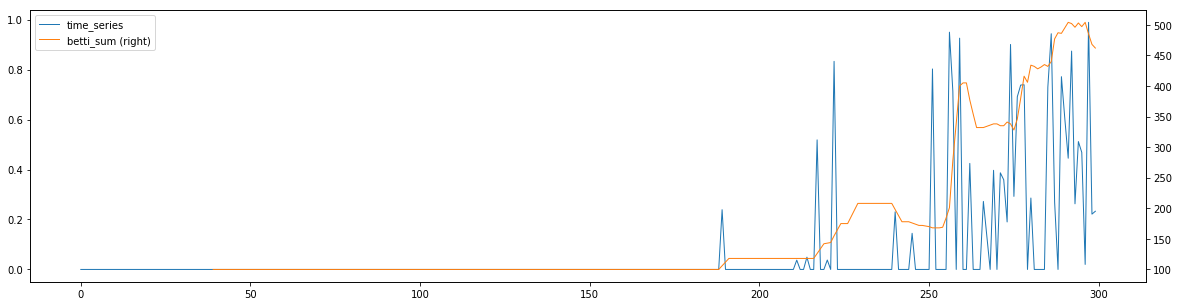

In [51]:
n_steps = 300
power = 7
time_series = [choice(a=[0, random.random()], p=[1-((x/float(n_steps))**power), (x/float(n_steps))**power ]) for x in range(n_steps)]

bt_sum = time_series_rolling_betti(time_series=pd.Series(time_series),
                                   epsilon_range=np.array([y*.01 for y in range(100)]),
                                   max_simplex_dim=3,
                                   window=40,
                                   agg='sum')



bt_sum.rename(columns={0: 'time_series', 'betti': 'betti_sum'}, inplace=True)

bt_sum.plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    secondary_y='betti_sum'
);